In [1]:
import sys
import os
proj_path = "/home/mt622/GitHubRepos/FractionalBrownianMotion"
proj_path = os.path.abspath(proj_path)
sys.path.append(proj_path)
print(sys.path)

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/generative_modelling/RecursiveVPSDE/ParameterEstimation/PM', '/Users/marcos/GitHubRepos/FractionalBrownianMotion', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages', '/home/mt622/GitHubRepos/FractionalBrownianMotion']


In [1]:
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from configs.RecursiveVPSDE.recursive_PostMeanScore_fOU_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()

rng = np.random.default_rng()
num_simulated_paths = 500
drift_eval_diff_time = int(config_postmean.max_diff_steps - 9000)
data_shape = (num_simulated_paths, 1, 1)
device = "cpu"

revDiff_time_scale = torch.linspace(start=config_postmean.end_diff_time, end=config_postmean.sample_eps,
                                 steps=config_postmean.max_diff_steps).to(device)
real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length

In [75]:
from scipy.stats import wasserstein_distance
import ot
def get_true_drifts_from_paths(config, paths):
    true_drifts = (-1 * config.mean_rev * paths)
    return true_drifts[:,:-1]
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((500,)) / 500  # Uniform weights for X
    b = np.ones((500,)) / 500  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    print(a.shape, b.shape, M.shape)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    print(bootstrap_distances, observed_distance)
    p_value = np.mean(bootstrap_distances >= observed_distance)


    return observed_distance, p_value

In [67]:
import re
import os
def extract_number(s):
    match = re.search(r'NEp(\d+)', s)
    return int(match.group(1)) if match else 0
rootpath = project_config.ROOT_DIR + f"experiments/results/"
files = os.listdir(rootpath)
keepfiles = []
for file in files:
    if "rec" in file and "pNEp" not in file and "aNEp" not in file  and "_PM_" in file and "ea" not in file and "ep" not in file and "e2" not in file and "NEp" in file and "fOUv" not in file and "fOUm" not in file and "fSin" not in file and "v0" not in file and "m0" not in file and "fBm" not in file and "H7" not in file and "markv" not in file:
        keepfiles.append(rootpath + file)
print(len(keepfiles))
sortedkeep = sorted(keepfiles, key=extract_number)
sortedkeep = [sortedkeep[3],sortedkeep[4]]

14


In [68]:
import pandas as pd
for file in sortedkeep:
    paths = pd.read_csv(file, compression="gzip").to_numpy()[:,2:].cumsum(axis=1)
    paths = paths[np.random.choice(np.arange(paths.shape[0]), 500, replace=False),:]
    print(file)
    for pathid in range(500):
        plt.scatter(np.arange(256), paths[pathid,:], s=10)
    plt.show()
    plt.close()

KeyboardInterrupt: 

In [69]:
rootpath = project_config.ROOT_DIR + f"experiments/results/"
files = os.listdir(rootpath)
keepfiles = []
for file in files:
    if "_PM_" in file and "_m0" in file and "fOUm" in file and ("erNEp960" in file or "erNEp1440" in file):
        keepfiles.append(rootpath + file)
print(len(keepfiles))
sortedkeep_drifts = sorted(keepfiles, key=extract_number)
sortedkeep_drifts

2


['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOUm_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_m0_tl5_erNEp960_P1.csv.gzip',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOUm_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_m0_tl5_erNEp1440_P1.csv.gzip']

In [70]:
sortedkeep

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_erNEp960.csv.gzip',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/rec_PM_TSM_False_incs_True_unitIntv_fOU_VPSDE_model_H5000e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20000e+01_BetaMin10000e-04_DiffEmbSize64_ResLay10_ResChan8_DiffHiddenSize64_TrueHybrid_TrueWghts_LSTM_H20_Nlay1_fOU00_tl5_erNEp1440.csv.gzip']

960
(40000, 256)


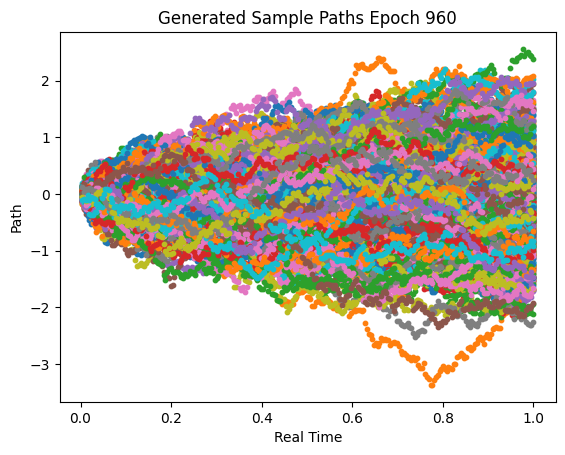

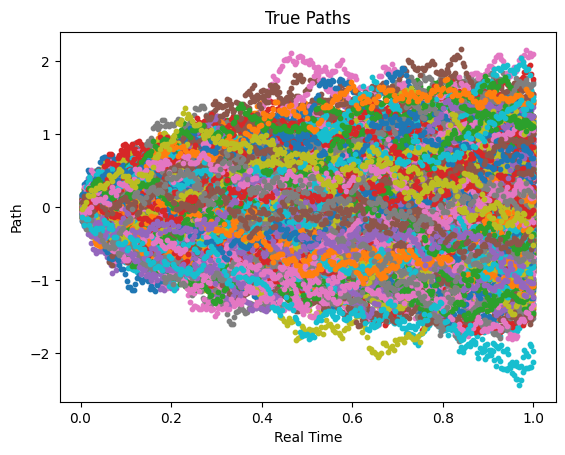

1440
(40000, 256)


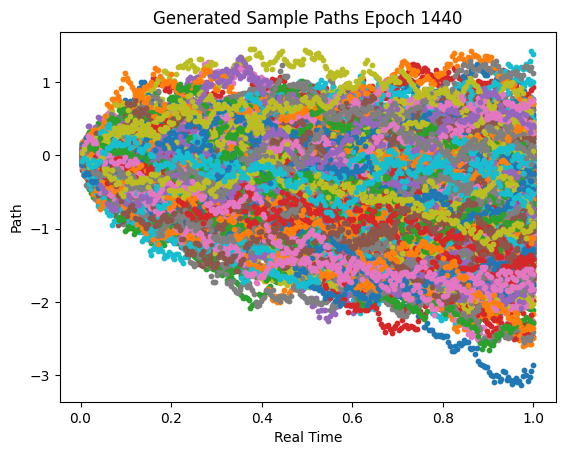

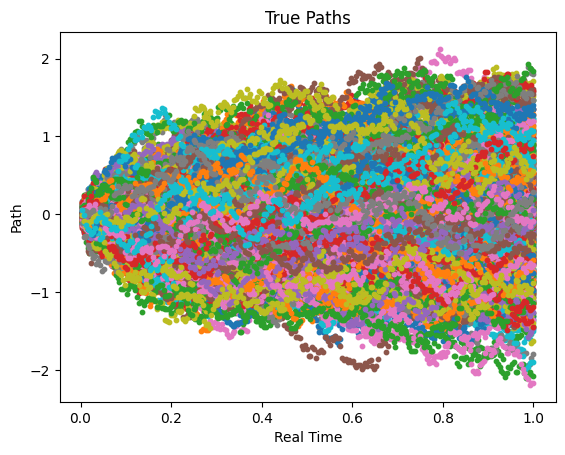

In [73]:
# Plot the drift estimator for different sample paths across time
for file in sortedkeep:
    try:
        t = int(re.search(r'NEp(\d+)',file).group(1))
        print(t)
        paths = pd.read_csv(file, compression="gzip").to_numpy()[:,2:].cumsum(axis=1)
        print(paths.shape)
        eval_ts_length = paths.shape[1]
        synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), 500, replace=False),:]
        synthetic_paths = synthetic_paths[:,:paths.shape[1]]
        #print(bootstrap_test_wasserstein(postMean_prevPaths.numpy(), synthetic_paths)[1])
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), paths[pathid,:], s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"Generated Sample Paths Epoch {t}")
        plt.show()
        plt.close()
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), synthetic_paths[pathid,:], s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"True Paths")
        plt.show()
        plt.close()
    except FileNotFoundError:
        pass

In [79]:
experiment_emses = {t: None for t in config_postmean.max_epochs}
experiment_rel_emses = {t: None for t in config_postmean.max_epochs}
for i in range(2):
    try:
        t = int(re.search(r'NEp(\d+)', sortedkeep[i]).group(1))
        print(t)
        paths = pd.read_csv(sortedkeep[i], compression="gzip").to_numpy()[:,2:].cumsum(axis=1)
        drift_est = pd.read_csv(sortedkeep_drifts[i], compression="gzip").to_numpy()[:,2:]
        true_drift = get_true_drifts_from_paths(config_postmean, paths)
        #bias2 = torch.pow(true_drift.unsqueeze(-1) - drift_est,2).mean(axis=0)
        print(true_drift.shape, drift_est.shape)
        bias2 = torch.pow(true_drift.unsqueeze(-1) - drift_est.mean(axis=0).reshape(-1,1),2).mean(axis=0)
        variance = torch.var(drift_est, axis=0)
        del drift_est
        emses = bias2 + variance
        experiment_emses[t] = emses
        print((emses / torch.pow(true_drift, 2).mean(axis=0).unsqueeze(-1)).shape)
        experiment_rel_emses[t] = emses / torch.pow(true_drift, 2).mean(axis=0).unsqueeze(-1)
    except FileNotFoundError:
        pass

960
(40000, 255) (40000, 256)


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

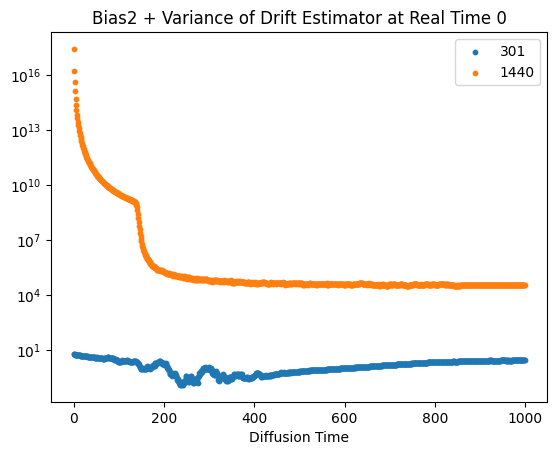

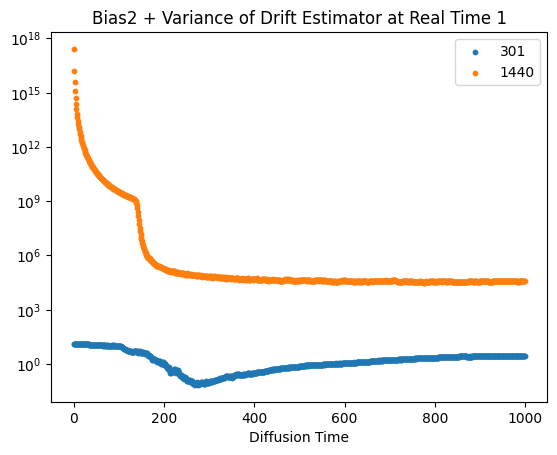

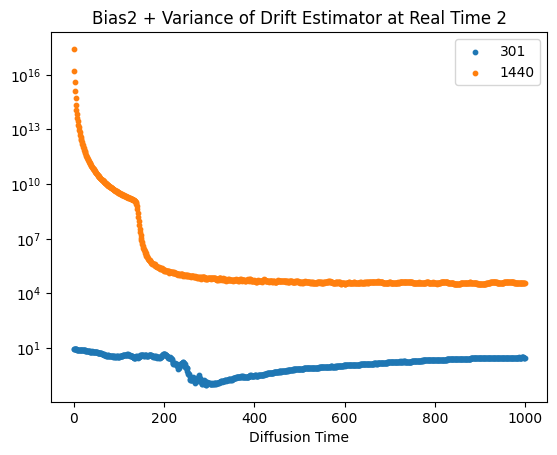

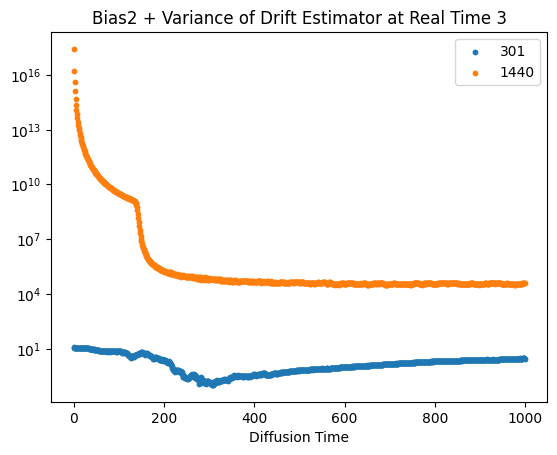

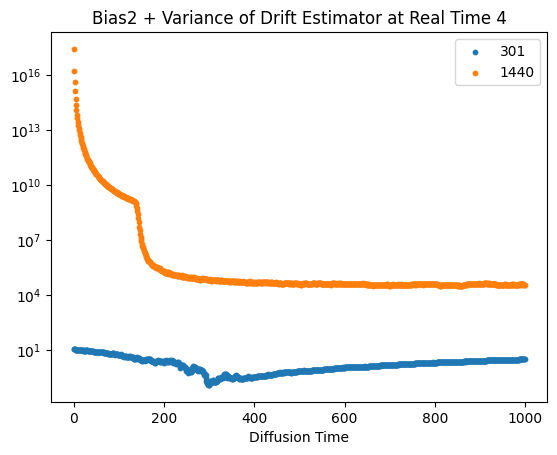

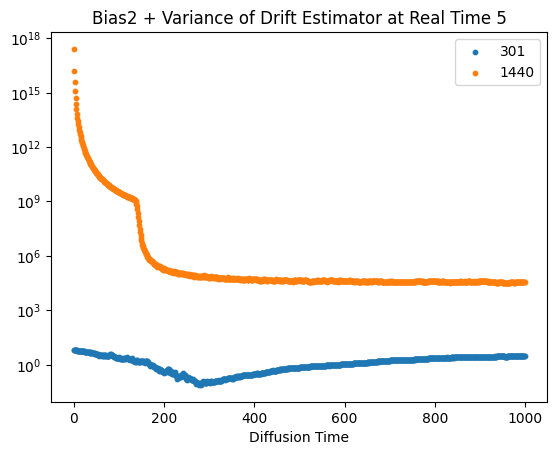

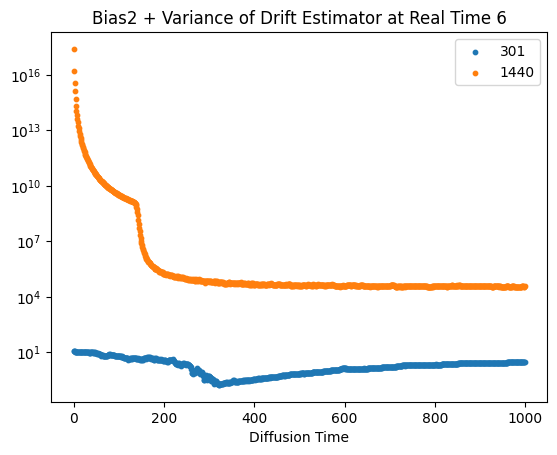

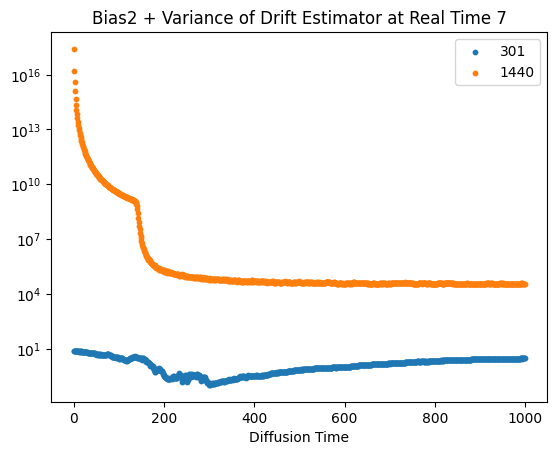

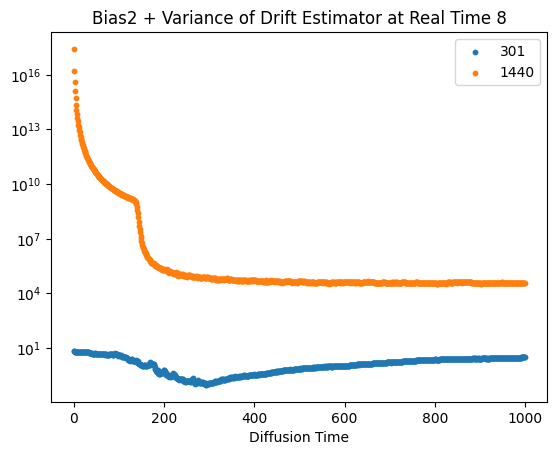

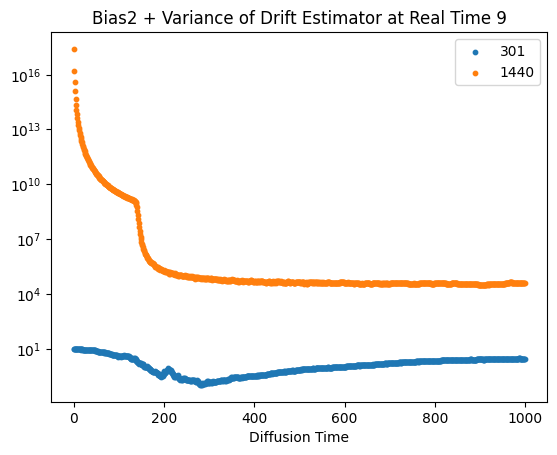

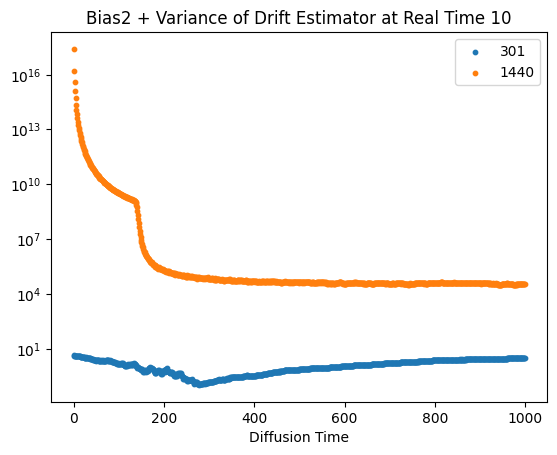

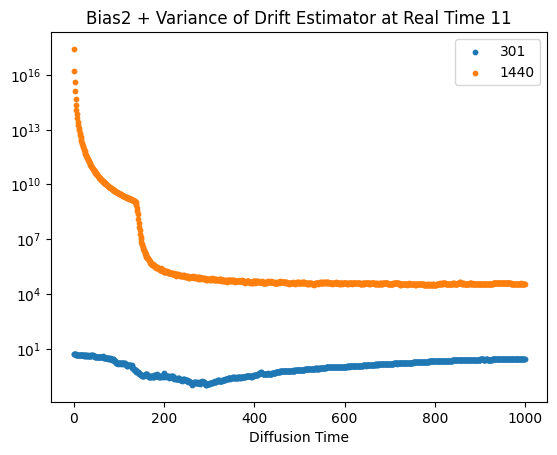

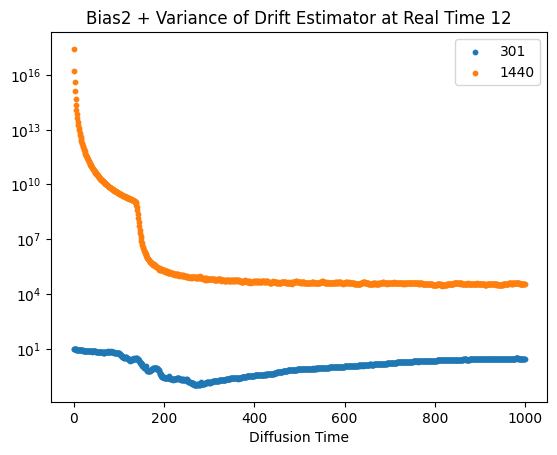

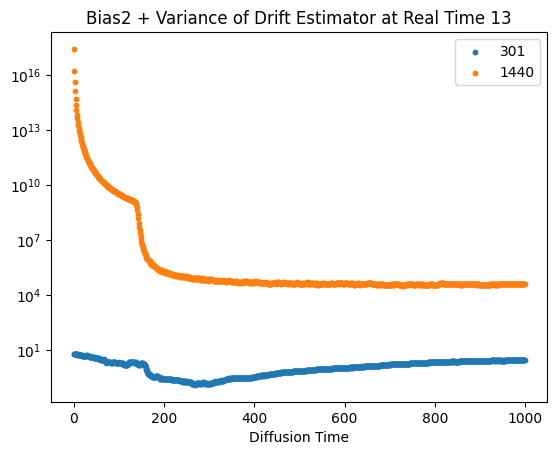

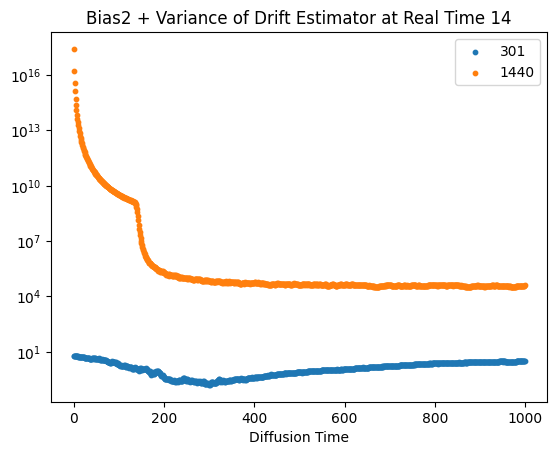

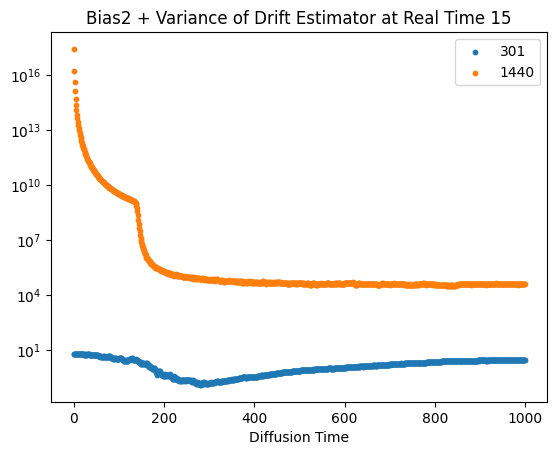

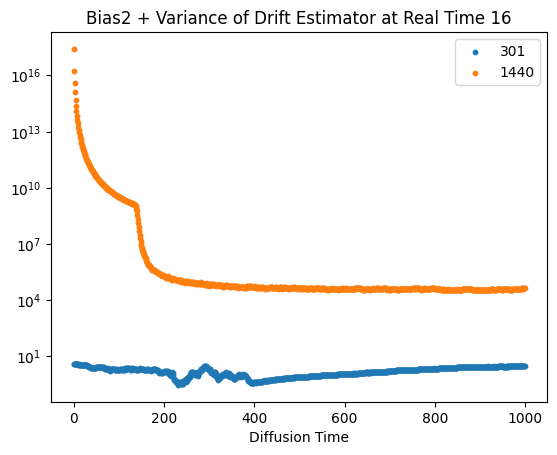

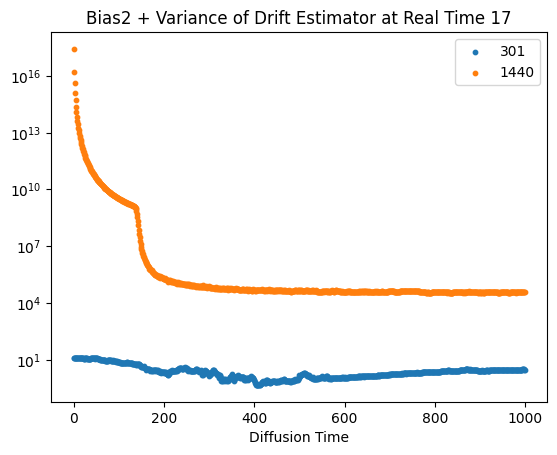

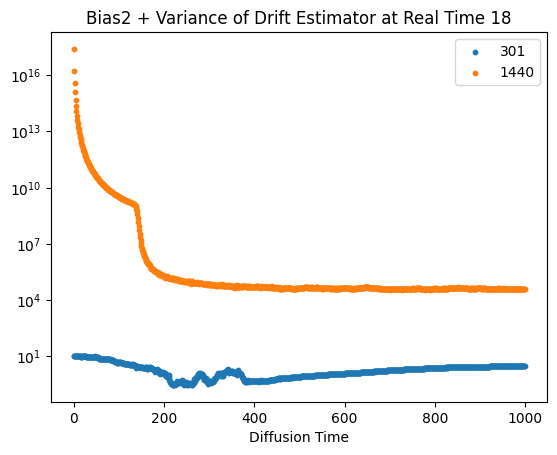

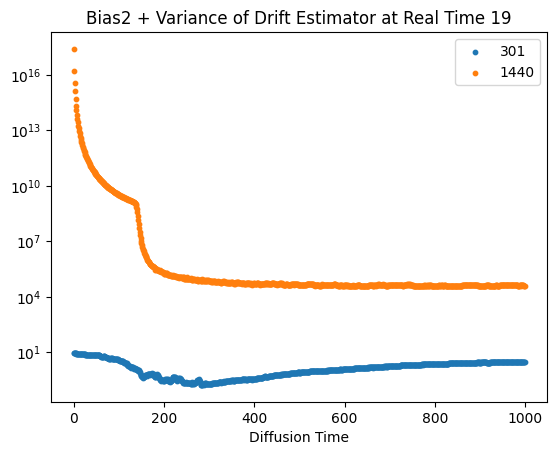

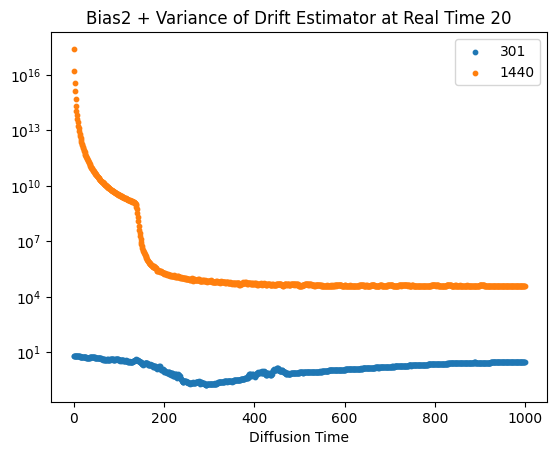

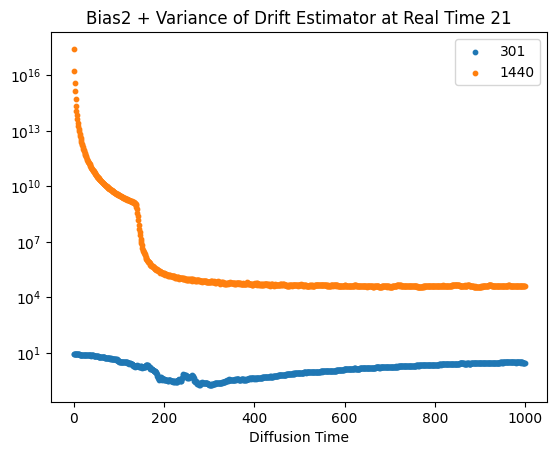

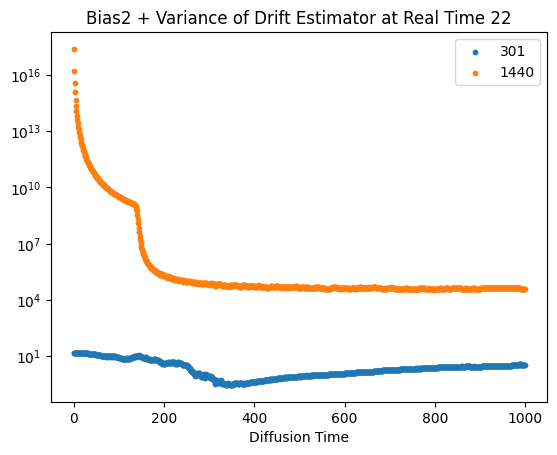

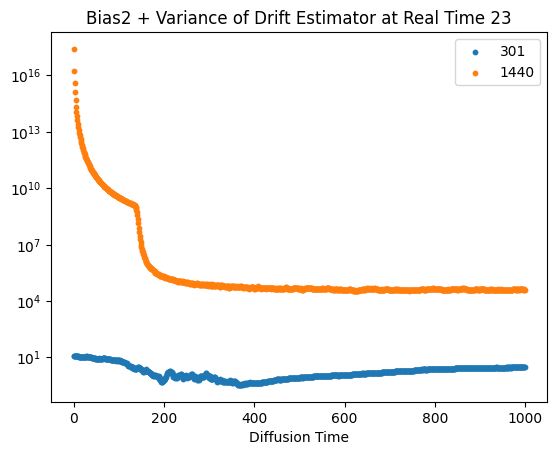

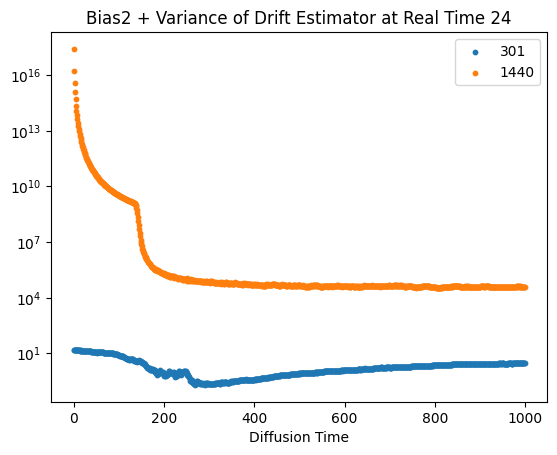

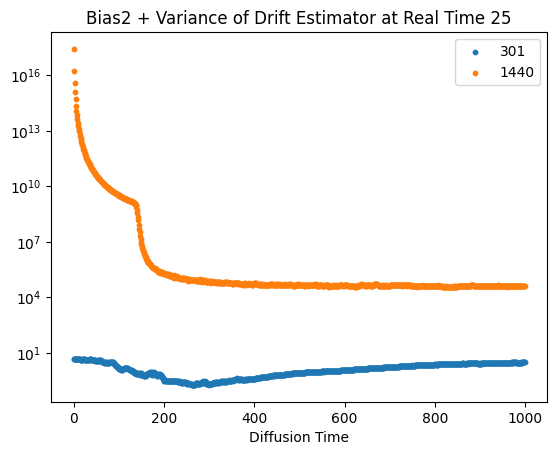

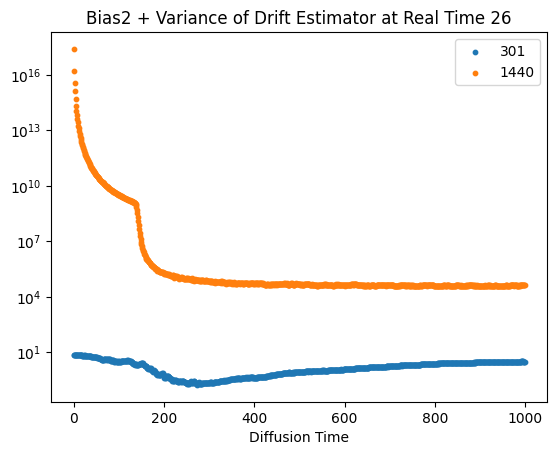

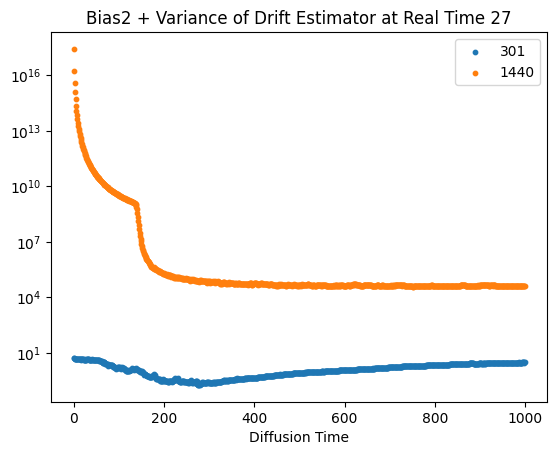

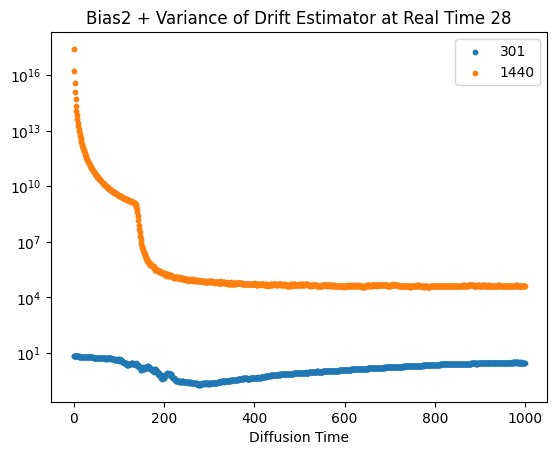

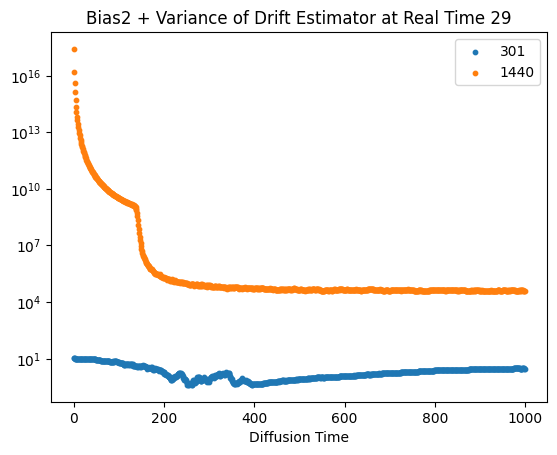

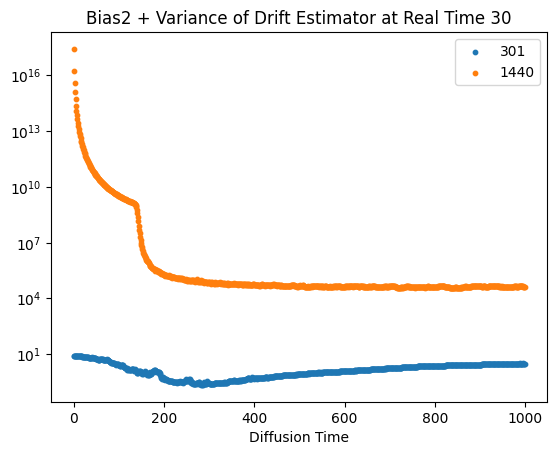

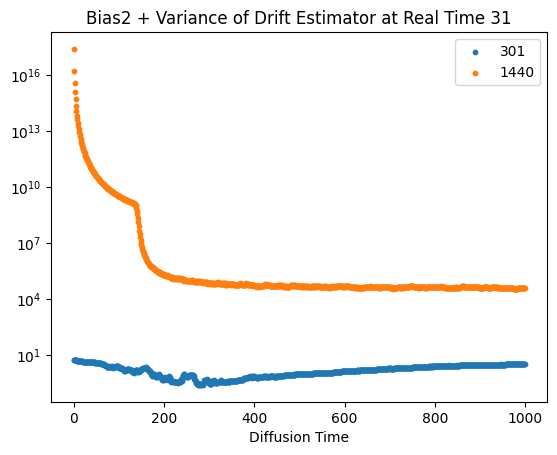

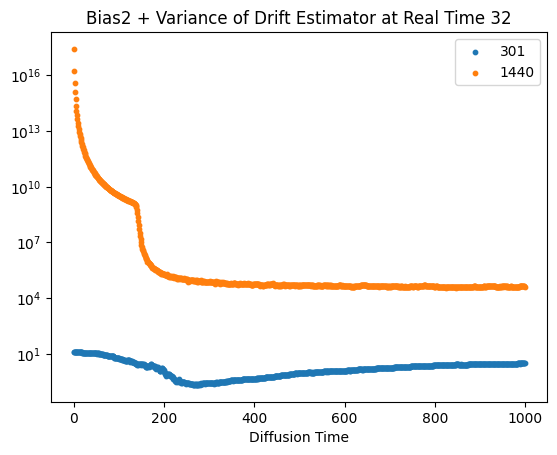

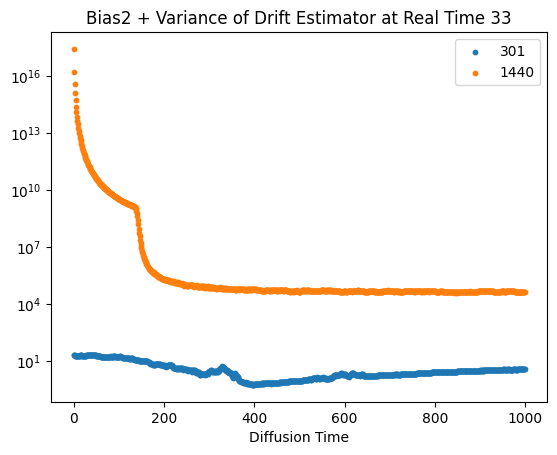

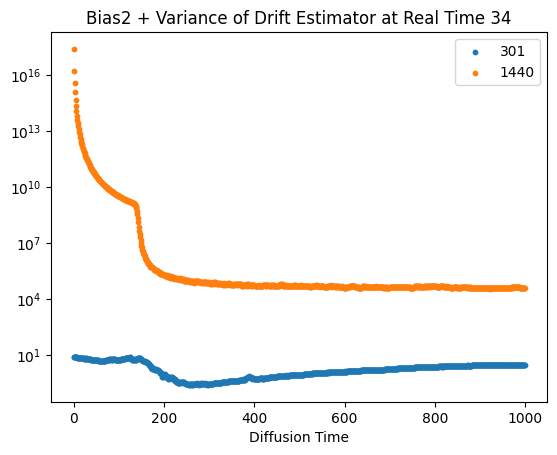

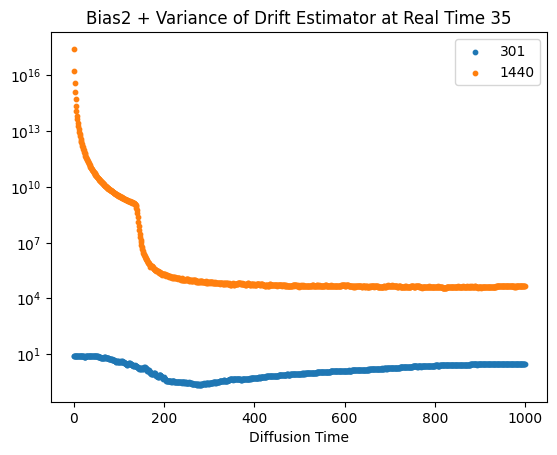

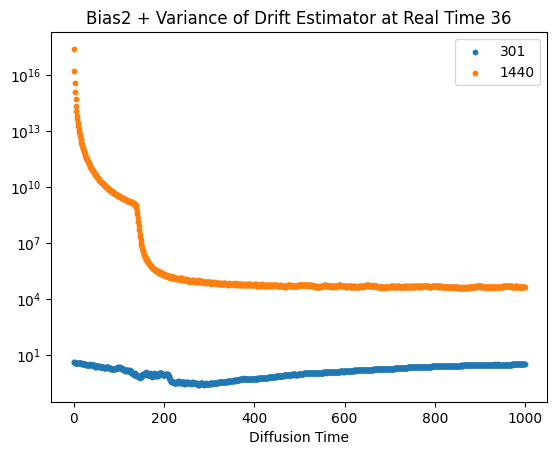

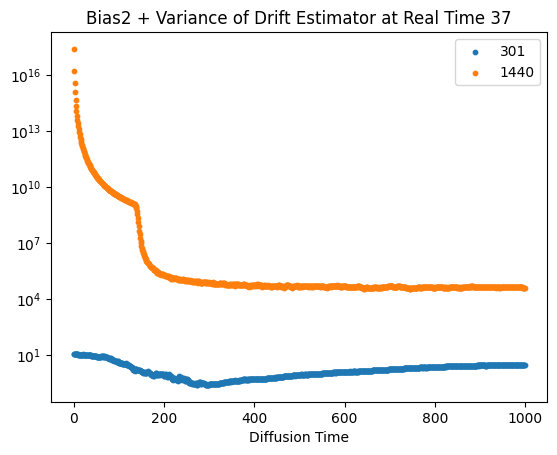

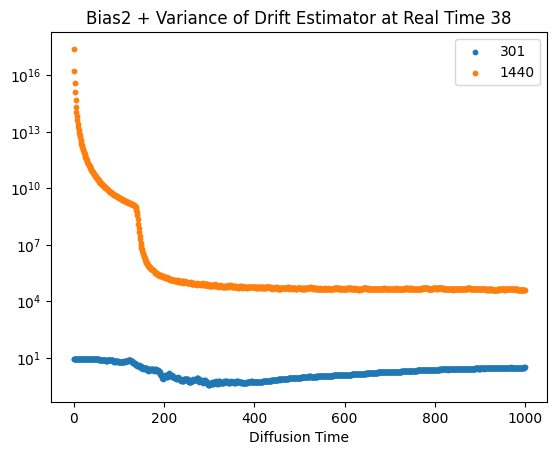

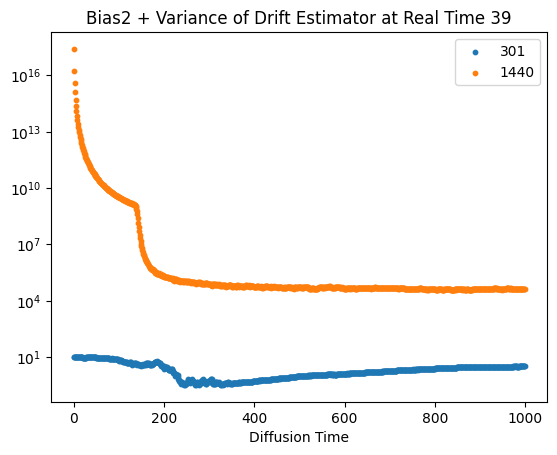

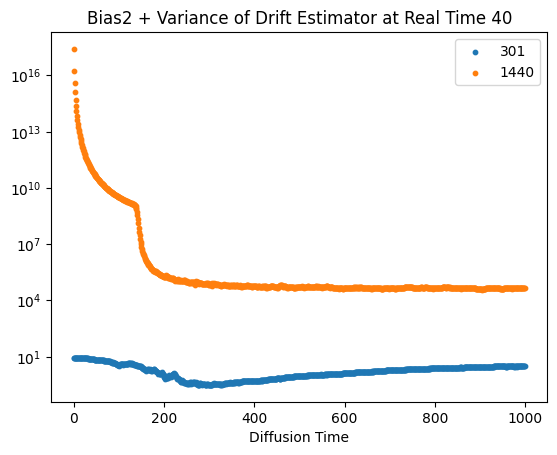

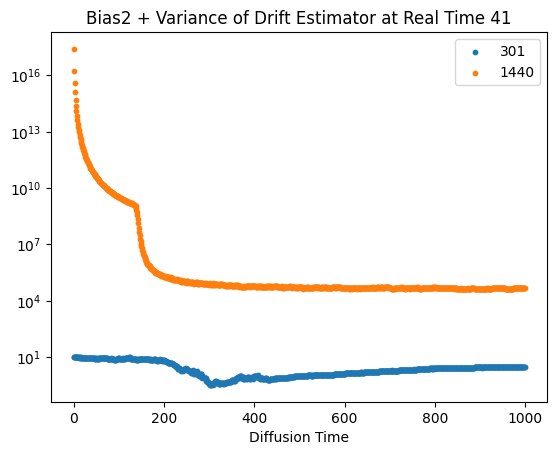

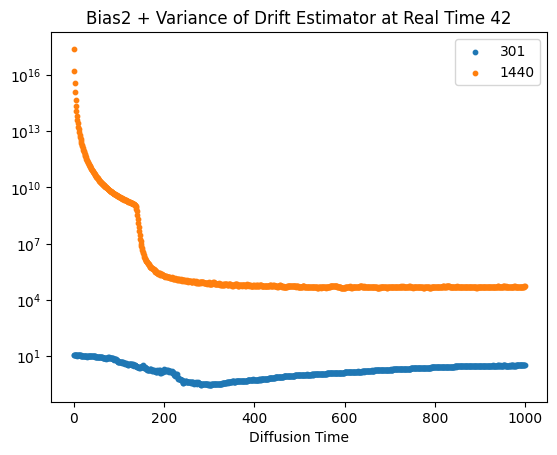

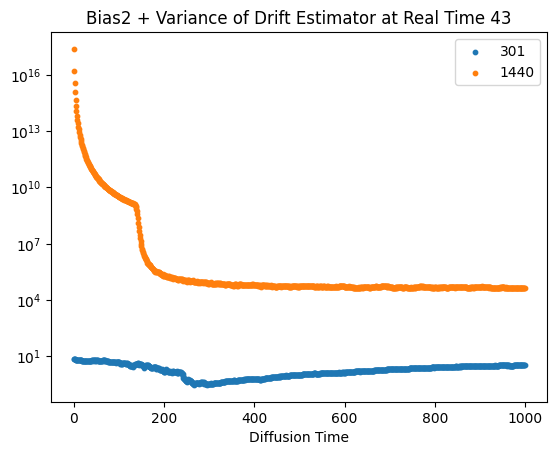

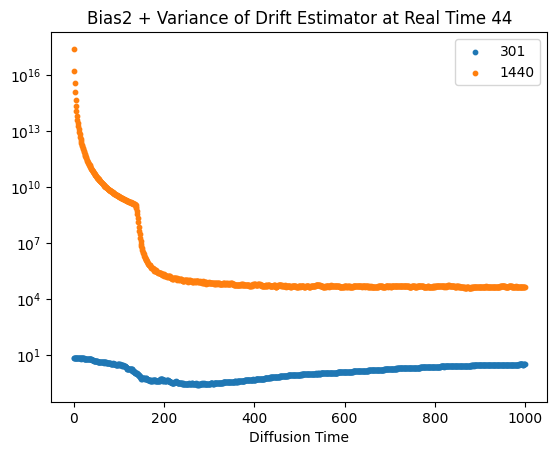

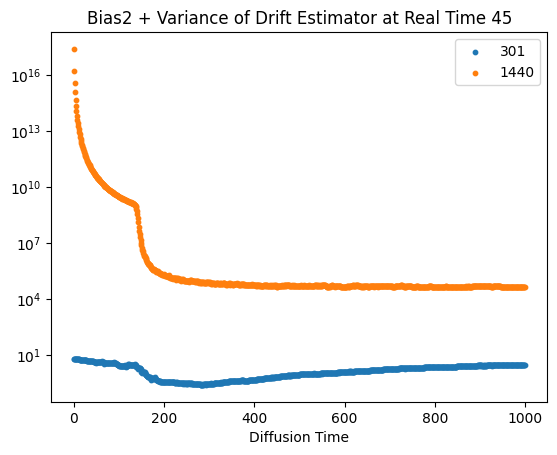

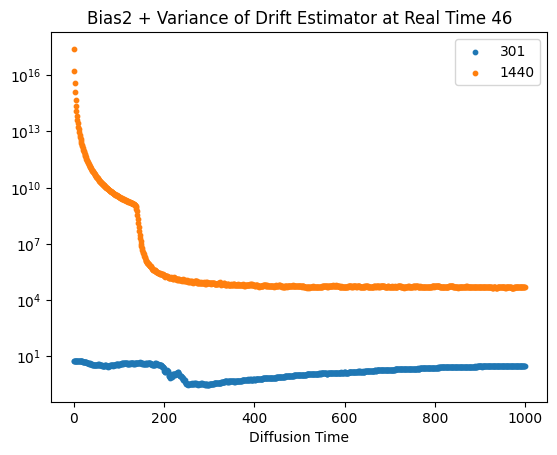

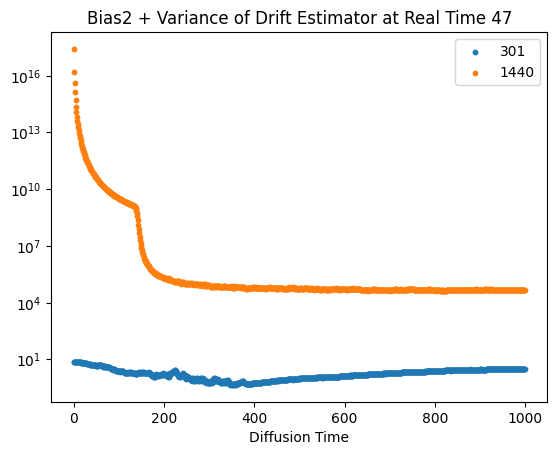

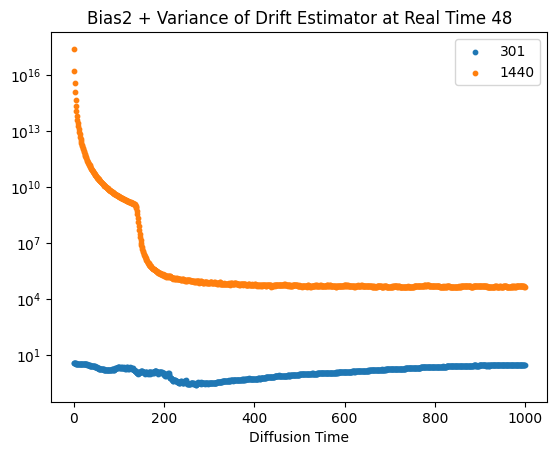

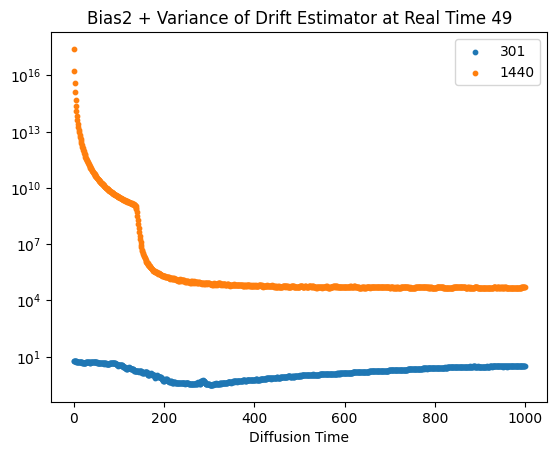

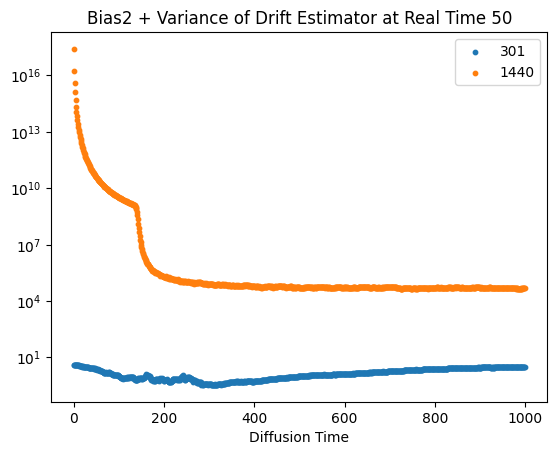

In [11]:
eval_ts_length = 256
for t in range(eval_ts_length):
    for key, values in experiment_emses.items():
        try:
            plt.scatter(np.arange(0, 1000), values[t, :1000], s=10, label=f"{key}")
            plt.title(f"Bias2 + Variance of Drift Estimator at Real Time {t}")
        except TypeError:
            pass
    plt.legend()
    plt.xlabel("Diffusion Time")
    plt.yscale("log")
    plt.show()
    plt.close()

tensor(283084.5312) 301
tensor(17.6822) 1440


ValueError: x and y must be the same size

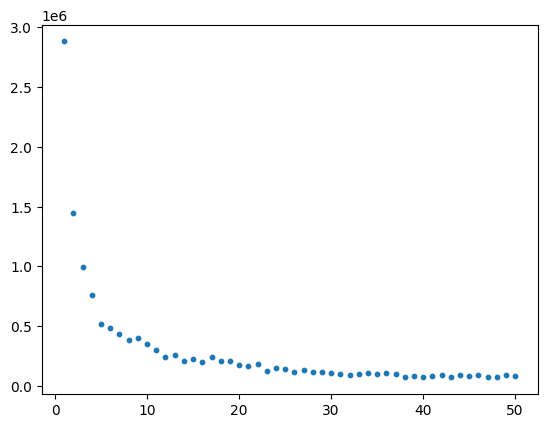

In [9]:
# Compute mean and bias2 for the drift estimates across different diffusion times
for Nepoch in config_postmean.max_epochs:
    try:
        rel_emses = experiment_rel_emses[Nepoch][:, 9000]
        print(torch.mean(rel_emses[1:]), Nepoch)
        plt.scatter(np.arange(eval_ts_length), rel_emses, s=10, label=f"Epoch {Nepoch}")
    except TypeError:
        pass
plt.title(f"Normalised EMSE of Drift Estimator Across Real Times")
plt.xlabel("Real Time")
plt.legend()
plt.yscale("log")
plt.show()
plt.close()